In [1]:
import numpy as np  # probably don't need to load
import pandas as pd
import datetime as dt
#import pandas_datareader.data as web  # probably don't need to load
#import quandl
import blpapi
from xbbg import blp

import matplotlib.pyplot as plt
#import seaborn as sns

In [21]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Start with reading Jeff's Master sheet
- this comes from BMS (onex.blkmtn.com/?db=238)  columns B:BD
- columns BA to BD of that tab to calculate the WARF using the new logic that Moody’s released (see new WARF section)
- The CLO 21 Port as of 3.18 tab contains the actual portfolio of CLO 21 as of 3/18 which also feeds into the Model Portfolio tab (column H and K).

In [12]:
filepath = 'Z:/Shared/Risk Management and Investment Technology/Files for sharing/'
file = 'CLO21 model portfolio as of 03.18.21 - With New WARF Logic.xlsm'

# derived data in MASTER are as follows:
# column A 'combined' is just concat('Issuer','-','Asset')
# all the above is trivial to add later when spreadsheet read gets replaced
# by reading directly from BMS

master_df = pd.read_excel(filepath + file,sheet_name='MASTER',header=1)
master_df = master_df.loc[:,~master_df.columns.str.match("Unnamed")]

In [13]:
# looks like LoanX ID makes the most sense as the index
master_df

,Combined,LoanX ID,Parent Company,Issuer,Asset,Analyst,Floating Spread,Floating Spread Floor,All In Rate,Maturity Date,...,Issuer Country,Cov Lite,Default,Libor Contract,Loan Only,Comments,Moody's ADJ. CFR Score,Adjusted CFR Score,Adjusted CFR for WARF,Adj. WARF NEW
0,CNT Holdings I Corp - Initial Term Loan (Secon...,LX190245,1-800 Contacts,CNT Holdings I Corp,Initial Term Loan (Second Lien),Adey Delbridge,0.0675,0.0075,0.075000,2028-11-06,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490
1,CNT Holdings I Corp - Initial Term Loan (First...,LX190219,1-800 Contacts,CNT Holdings I Corp,Initial Term Loan (First Lien),Adey Delbridge,0.0375,0.0075,0.045000,2027-11-08,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490
2,1011778 B.C. Unlimited Liability Company (New ...,LX182732,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,Term A Loan,Rekha Nayar,0.0125,NaN,0.014913,2024-09-06,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766
3,1011778 B.C. Unlimited Liability Company (New ...,USC6900PAL34,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,3.500% - 02/2029 - USC6900PAL34 REGS,Rekha Nayar,NaN,NaN,0.035000,2029-02-15,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766
4,1011778 B.C. Unlimited Liability Company (New ...,LX183929,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,Term B-4 Loan,Rekha Nayar,0.0175,0.0000,0.019913,2026-11-19,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,zz_LXREP22 - Rep Line - 22,LXREP22,LXREP22,zz_LXREP22,Rep Line - 22,NaN,0.0425,0.0075,NaN,2029-03-08,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490
492,zz_LXREP23 - Rep Line - 23,LXREP23,LXREP23,zz_LXREP23,Rep Line - 23,NaN,0.0450,0.0000,NaN,2029-03-09,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490
493,zz_LXREP24 - Rep Line - 24,LXREP24,LXREP24,zz_LXREP24,Rep Line - 24,NaN,0.0450,0.0075,NaN,2029-03-10,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490
494,zz_LXREP25 - Rep Line - 25,LXREP25,LXREP25,zz_LXREP25,Rep Line - 25,NaN,0.0475,0.0075,NaN,2029-03-11,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490


# Read CLO 21 Port as of 3.18

In [14]:
CLO_df = pd.read_excel(filepath + file,sheet_name='CLO 21 Port as of 3.18',header=6,usecols='A:K')
CLO_df.dropna(inplace=True)

# his pivot table columns M:0
CLO_df[['Cusip or LIN','Quantity','/Unit']].sort_values(by='Cusip or LIN')

In [22]:
CLO_df[['Quantity']].sum()  # verified sum of Quantity
CLO_df[['/Unit']].mean()    # verified for average /Unit

Quantity    2.263333e+08
dtype: float64

/Unit    0.997052
dtype: float64

# Read Bid.Ask 3.18

In [23]:
# need to use str.match so it isn't date dependent
bidask_df = pd.read_excel(filepath + file,sheet_name='Bid.Ask 3.18',header=0)
bidask_df = bidask_df.loc[:,~bidask_df.columns.str.match("Unnamed")]

,LXID,Issuer Name,Deal Name,Facility,Maturity,Initial Spread,Close Bid,Close Offer,Evaluated Price,Close Depth,As of Date,Currency,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,LX183500,Freshworld Hldg IV GmbH,ADCO Group 08/19,RC,2026-02-02,325.0,99.097,99.638,99.3675,implied,2021-03-18,EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LX183504,Clay Holdco BV,CRH Europe Distribution 10/19,RC,2025-10-30,30.0,89.000,93.000,91.0000,1,2021-03-18,EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LX158555,ATX Networks Corp,ATX Networks 12/16 Pico,TL,2023-12-31,600.0,88.000,95.000,91.5000,1,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LX183586,AIMBRIDGE ACQUISITION CO INC,Aimbridge Hospitality 10/19 Cov-Lite,TLB,2026-02-02,375.0,96.625,97.250,96.9375,2,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LX183588,NEXUS BUYER LLC,Promontory Interfinancial 10/19 Cov-Lite,TLB,2026-11-09,375.0,99.500,99.975,99.7375,5,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,LX181820,Owens IL Group Inc,Owens-Illinois 6/19 (USD),RC,2024-06-25,150.0,98.620,99.682,99.1510,implied,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6814,LX181829,MED PARENTCO LP,Capital Vision/MyEyeDr 8/19 Cov-Lite,RC,2024-08-29,300.0,98.342,99.108,98.7250,implied,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6815,LX181828,MED PARENTCO LP,Capital Vision/MyEyeDr 8/19 Cov-Lite,Delayed TL,2026-08-31,425.0,98.618,99.267,98.9425,9,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6816,LX181827,MED PARENTCO LP,Capital Vision/MyEyeDr 8/19 Cov-Lite,TL,2026-08-31,425.0,98.618,99.267,98.9425,9,2021-03-18,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# new WARF
- column BA looks up the 'CFR' score e.g. B3 and maps it to a number
- column BB adjusts +/- 1 if outlook is possible up/downgrade
- column BC converts back into an alpanumeric e.g. B3
- column BD maps the alphanumeric into the new WARF score (1-1000)

In [26]:
moodys_score = pd.read_excel(filepath + file,sheet_name='New WARF',header=0,usecols='E:F')
moodys_rfTable = pd.read_excel(filepath + file,sheet_name='New WARF',header=0,usecols='J:K')

In [73]:
# this works; spot checked
def moodys_adjusted_warf(df,moodys_score,moodys_rfTable):
    """
    This function creates the new Moody's Ratings Factor based 
    on the old Moody's rating.
    
    Arg in:
        df: the input data frame (from the MASTER table d/l'd from BMS)
        moodys_score: dataframe with alphanumeric rating to numeric map (1 to 1 map; linear)
        moodys_rfTable: dataframe with alphanumeric rating to new WARF numeric (1 to 1 map; 1 to 1000 values)
    """
    score = df['Moody\'s CFR'].map(dict(moodys_score[['Moodys','Score']].values))
    updown = df['Moody\'s Issuer Watch'].\
        apply(lambda x: 1 if x == 'Possible Upgrade' else -1 if x == 'Possible Downgrade' else 0)
    aScore = score + updown
    Adjusted_CFR_for_WARF = aScore.map(dict(moodys_score[['Score','Moodys']].values))
    # I keep the same column name as Jeff to make it easier to double check values
    df['Adj. WARF NEW'] = Adjusted_CFR_for_WARF.map(dict(moodys_rfTable[['Moody\'s Rating Factor Table','Unnamed: 10']].values))
    return df

In [74]:
master_df = moodys_adjusted_warf(master_df)
master_df

,Combined,LoanX ID,Parent Company,Issuer,Asset,Analyst,Floating Spread,Floating Spread Floor,All In Rate,Maturity Date,...,Issuer Country,Cov Lite,Default,Libor Contract,Loan Only,Comments,Moody's ADJ. CFR Score,Adjusted CFR Score,Adjusted CFR for WARF,Adj. WARF NEW
0,CNT Holdings I Corp - Initial Term Loan (Secon...,LX190245,1-800 Contacts,CNT Holdings I Corp,Initial Term Loan (Second Lien),Adey Delbridge,0.0675,0.0075,0.075000,2028-11-06,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0
1,CNT Holdings I Corp - Initial Term Loan (First...,LX190219,1-800 Contacts,CNT Holdings I Corp,Initial Term Loan (First Lien),Adey Delbridge,0.0375,0.0075,0.045000,2027-11-08,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0
2,1011778 B.C. Unlimited Liability Company (New ...,LX182732,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,Term A Loan,Rekha Nayar,0.0125,NaN,0.014913,2024-09-06,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766.0
3,1011778 B.C. Unlimited Liability Company (New ...,USC6900PAL34,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,3.500% - 02/2029 - USC6900PAL34 REGS,Rekha Nayar,NaN,NaN,0.035000,2029-02-15,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766.0
4,1011778 B.C. Unlimited Liability Company (New ...,LX183929,1011778 B.C. Unlimited Liability Company (New ...,1011778 B.C. Unlimited Liability Company (New ...,Term B-4 Loan,Rekha Nayar,0.0175,0.0000,0.019913,2026-11-19,...,CA,No,N,NaN,NaN,NaN,13,13,Ba3,1766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,zz_LXREP22 - Rep Line - 22,LXREP22,LXREP22,zz_LXREP22,Rep Line - 22,NaN,0.0425,0.0075,NaN,2029-03-08,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0
492,zz_LXREP23 - Rep Line - 23,LXREP23,LXREP23,zz_LXREP23,Rep Line - 23,NaN,0.0450,0.0000,NaN,2029-03-09,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0
493,zz_LXREP24 - Rep Line - 24,LXREP24,LXREP24,zz_LXREP24,Rep Line - 24,NaN,0.0450,0.0075,NaN,2029-03-10,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0
494,zz_LXREP25 - Rep Line - 25,LXREP25,LXREP25,zz_LXREP25,Rep Line - 25,NaN,0.0475,0.0075,NaN,2029-03-11,...,US,No,N,NaN,NaN,NaN,16,16,B3,3490.0


In [84]:
model_port = master_df.merge(CLO_df,left_on="LoanX ID",right_on="Cusip or LIN",how='outer').info()
#model_port = model_port.merge(bidask_df,left_on="LoanX ID",right_on="LXID",how='left').info()
model_port

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Combined                           496 non-null    object        
 1   LoanX ID                           496 non-null    object        
 2   Parent Company                     496 non-null    object        
 3   Issuer                             496 non-null    object        
 4   Asset                              496 non-null    object        
 5   Analyst                            462 non-null    object        
 6   Floating Spread                    488 non-null    float64       
 7   Floating Spread Floor              473 non-null    float64       
 8   All In Rate                        470 non-null    float64       
 9   Maturity Date                      494 non-null    datetime64[ns]
 10  Mark Price                         463

# S&P's Recovery Rate

In [194]:
#first_lien_rr = pd.read_excel(filepath + file, sheet_name='SP RR Updated', header=1, usecols='A:D')
#second_lien_rr = pd.read_excel(filepath + file, sheet_name='SP RR Updated', header=1, usecols='F:I')
new_sp_rr = pd.read_excel(filepath + file, sheet_name='SP RR Updated', header=1, usecols='L:M')
new_sp_rr.dropna(how='all',inplace=True)

lien_rr = pd.read_excel(filepath + file, sheet_name='SP RR Updated', header=1, usecols='A:I')
lien_rr.dropna(how='all',inplace=True)

bond_split = lien_rr[lien_rr['Country.1']=='Bonds'].index.values[0]
bond_table = lien_rr.loc[bond_split+1:]
lien_rr = lien_rr.loc[:bond_split-1]
lien_rr.drop(columns=['Unnamed: 4','Country Abv.1','Country.1','Group.1'],inplace=True)
lien_rr.rename(columns={'RR.1':'RR.2nd'},inplace=True)

In [198]:
def sp_recovery_rate(model_df):
    """
    This function get the S&P recovery rate as a percent. If it doesn't exist
    in the master field, it will look up in the appropriate first and second 
    lien tables, if not, will look up the bond table.
    
    Arg in:
        model_df: the input data frame (from the MASTER table d/l'd from BMS)
    Arg out:
        model_df with inserted new column 'S&P Recovery Rate (AAA)'
    """
     
    # if it the Recovery rate exists lookup in AAA table
    model_df['S&P Recovery Rate (AAA)'] = model_df['S&P Recovery'].\
        map(dict(new_sp_rr[['S&P Recovery Rating\nand Recovery\nIndicator of\nCollateral Obligations','“AAA”']].values))
    
    # doesn't exist, but first lien, use first lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'S&P Recovery Rate (AAA)'] =\
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'First Lien'),'Issuer Country'].\
        map(dict(lien_rr[['Country Abv','RR']].values))
    
    bond_split = second_lien_rr[second_lien_rr['Country.1']=='Bonds'].index.values[0]
    # doesn't exist, but 2nd lien, use 2nd lien table
    model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_df['S&P Recovery']) & (model_df['Lien Type']== 'Second Lien'),'Issuer Country'].\
        map(dict(lien_rr[['Country Abv','RR.2nd']].values))
    
    # the bonds
    model_df.loc[pd.isna(model_port['S&P Recovery']) & pd.isna(model_df['Lien Type']),'S&P Recovery Rate (AAA)'] = \
        model_df.loc[pd.isna(model_port['S&P Recovery']) & pd.isna(model_df['Lien Type']),'Issuer Country'].\
        map(dict(bond_table[['Country Abv.1','RR.1']].values))

    return model_df

In [199]:
model_port = sp_recovery_rate(model_port)
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 69 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Combined                           496 non-null    object        
 1   LoanX ID                           496 non-null    object        
 2   Parent Company                     496 non-null    object        
 3   Issuer                             496 non-null    object        
 4   Asset                              496 non-null    object        
 5   Analyst                            462 non-null    object        
 6   Floating Spread                    488 non-null    float64       
 7   Floating Spread Floor              473 non-null    float64       
 8   All In Rate                        470 non-null    float64       
 9   Maturity Date                      494 non-null    datetime64[ns]
 10  Mark Price                         463

# Diversity Score

In [218]:
div_df = model_port[['Moody\'s Industry','Parent Company','Par_no_default']].copy()
div_df.sort_values(by='Moody\'s Industry',inplace=True)

div_df[['Par_no_default']].mean()
div_df[['Par_no_default']].sum()
div_df[['Par_no_default']].count()

Par_no_default    1.782152e+06
dtype: float64

Par_no_default    2.263333e+08
dtype: float64

Par_no_default    127
dtype: int64

In [219]:
#div_df['EU'] = 1 if (div_df[['Par_no_default']]/div_df[['Par_no_default']].mean() > 1) else (div_df[['Par_no_default']]/div_df[['Par_no_default']].mean())
#div_df[['Par_no_default']].apply(lambda x: 1 if x.any()/x.mean() > 1 else x.any()/x.mean())
div_df['EU'] = div_df[['Par_no_default']]/div_df[['Par_no_default']].mean()
div_df.loc[div_df['EU']>1,'EU']=1
div_df

,Moody's Industry,Parent Company,Par_no_default,EU
430,Aerospace & Defense,"United AirLines, Inc.",NaN,NaN
444,Aerospace & Defense,Vertex Aerospace LLC,2613833.58,1.0000
175,Aerospace & Defense,EaglePicher,NaN,NaN
174,Aerospace & Defense,EaglePicher,NaN,NaN
445,Aerospace & Defense,Vertex Aerospace LLC,NaN,NaN
...,...,...,...,...
96,Utilities: Electric,Calpine Corporation,NaN,NaN
50,Utilities: Electric,Astoria Energy LLC,1412000.00,0.7923
98,Utilities: Electric,Calpine Corporation,NaN,NaN
438,Wholesale,"US Foods, Inc. (aka U.S. Foodservice, Inc.)",NaN,NaN


In [220]:
div_df.groupby(['Moody\'s Industry']).sum()

,Par_no_default,EU
Moody's Industry,,
Aerospace & Defense,4608079.11,2.119010
Automobile,5197691.63,2.573205
Automotive,0.00,0.000000
"Banking, Finance, Insurance & Real Estate",15489985.05,7.017895
"Beverage, Food, & Tobacco",12173413.34,5.061223
Broadcasting and Entertainment,2000000.00,1.000000
Capital Equipment,7941734.36,4.211783
Cargo Transport,0.00,0.000000
"Chemicals, Plastics and Rubber",0.00,0.000000


In [226]:
ind_avg_eu = pd.read_excel(filepath + file, sheet_name='Diversity', header=8, usecols='K:L')
ind_avg_eu.dropna(how='all',inplace=True)
ind_avg_eu

,Aggregate\nIndustry\nEquivalent\nUnit Score,Industry\nDiversity\nScore
0,0.00,0.00
1,0.05,0.10
2,0.15,0.20
3,0.25,0.30
4,0.35,0.40
...,...,...
196,19.55,4.96
197,19.65,4.97
198,19.75,4.98
199,19.85,4.99


In [230]:
np.sqrt(ind_avg_eu['Aggregate\nIndustry\nEquivalent\nUnit Score'])

0      0.000000
1      0.223607
2      0.387298
3      0.500000
4      0.591608
         ...   
196    4.421538
197    4.432832
198    4.444097
199    4.455334
200    4.466542
Name: Aggregate\nIndustry\nEquivalent\nUnit Score, Length: 201, dtype: float64

<AxesSubplot:>

2.995732273553991

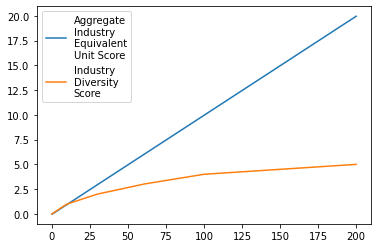

In [228]:
ind_avg_eu.plot()  # looks like sqrt() or log() shifted/scaled


In [225]:
#test = div_df.groupby(['Moody\'s Industry']).sum()
#test['Ind_Div_Score'] = 
test['EU'].map(dict(ind_avg_eu[['Aggregate\nIndustry\nEquivalent\nUnit Score','Industry\nDiversity\nScore']].values))

Moody's Industry
Aerospace & Defense                          NaN
Automobile                                   NaN
Automotive                                   0.0
Banking, Finance, Insurance & Real Estate    NaN
Beverage, Food, & Tobacco                    NaN
Broadcasting and Entertainment               NaN
Capital Equipment                            NaN
Cargo Transport                              0.0
Chemicals, Plastics and Rubber               0.0
Chemicals, Plastics, & Rubber                NaN
Construction & Building                      NaN
Consumer Goods: Durable                      NaN
Consumer Goods: Non-durable                  NaN
Containers, Packaging, & Glass               NaN
Energy: Electricity                          NaN
Energy: Oil & Gas                            NaN
Environmental Industries                     NaN
Healthcare & Pharmaceuticals                 NaN
High Tech Industries                         NaN
Hotel, Gaming & Leisure                      0.0
Hot

In [ ]:
def diversity_score(model_df):
    div_df = model_df[['Moody\'s Industry','Parent Company','Par_no_default']].copy()
    div_df.sort_values(by='Moody\'s Industry',inplace=True)
    div_df
    
    return dscore

# Model Portfolio stats
- Estimated Libor
- Minimum Floating Spread Test - Without Libor Floors
- Minimum Floating Spread Test - WithLibor Floors (adj. All in Rate)
- Maximum Moody's Rating Factor Test
- Maximum Moody's Rating Factor Test (NEW WARF)
- Maximum Moody's Rating Factor Test (Orig WARF)
- Minimum Weighted Average Moody's Recovery Rate Test
- Minimum Weighted Average S&P Recovery Rate Class A-1a
- Moody's Diversity Test
- WAP (Current Positions use Actual purchase price, all others use Ask price)
- Total Portfolio Par (excluding Defaults)
- Total Portfolio Par
- Current Portfolio 

- Replines	
- Amount	$79.2 
- WAS	3.80%
- WAPP	 99.5 
- WARF New	 3,022 
- WARF Orig	 2,954 


In [98]:
model_port = master_df.merge(CLO_df,left_on="LoanX ID",right_on="Cusip or LIN",how='outer')
#model_port = model_port.merge(bidask_df,left_on="LoanX ID",right_on="LXID",how='left').info()
model_port.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Combined                           496 non-null    object        
 1   LoanX ID                           496 non-null    object        
 2   Parent Company                     496 non-null    object        
 3   Issuer                             496 non-null    object        
 4   Asset                              496 non-null    object        
 5   Analyst                            462 non-null    object        
 6   Floating Spread                    488 non-null    float64       
 7   Floating Spread Floor              473 non-null    float64       
 8   All In Rate                        470 non-null    float64       
 9   Maturity Date                      494 non-null    datetime64[ns]
 10  Mark Price                         463

In [100]:
model_port['Par_no_default'] = model_port['Quantity']
model_port.loc[model_port['Default']=='Y','Par_no_default'] = 0


In [110]:
(model_port['Par_no_default']*model_port['Floating Spread']).sum()/model_port['Par_no_default'].sum()
#model_port[['Quantity','Par_no_default','Floating Spread']].sum()
#(model_port['Par_no_default']*model_port['Floating Spread']).sum()/(model_port['Par_no_default'].sum())

0.032778781332781816

In [ ]:
def Port_stats(model_df):
    Port_stats_df = pd.Dataframe(np.nan,index=['Min Floating Spread Test - no Libor Floors',
        'Min Floating Spread Test - With Libor Floors',
        'Max Moodys Rating Factor Test (NEW WARF)',
        'Max Moodys Rating Factor Test (Orig WARF)',
        'Min Moodys Recovery Rate Test',
        'Min S&P Recovery Rate Class A-1a',
        'Moodys Diversity Test',
        'WAP',
        'Total Portfolio Par (excl. Defaults)'
        'Total Portfolio Par'
        'Current Portfolio'],columns = ['Portfolio Stats'])
    model_df['Par_no_default'] = model_df['Quantity']
    model_df.loc[model_df['Default']=='Y','Par_no_default'] = 0
    
    Port_stats_df['Min Floating Spread Test - no Libor Floors'] = model_df['Par_no_default']*model_df['Floating Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['Min Floating Spread Test - With Libor Floors'] = model_df['Par_no_desoufault']*model_df['All In Rate']/sum(model_df['Par_no_default'])
    Port_stats_df['Max Moodys Rating Factor Test (NEW WARF)'] = model_df['Par_no_default']*model_df['Adj. WARF NEW']/sum(model_df['Par_no_default'])
    Port_stats_df['Max Moodys Rating Factor Test (Orig WARF)'] = model_df['Par_no_default']*model_df['WARF']/sum(model_df['Par_no_default'])
    Port_stats_df['Min Moodys Recovery Rate Test'] = model_df['Par_no_default']*model_df['Moodys Recovery Rate']/sum(model_df['Par_no_default'])
    
    Port_stats_df['Min S&P Recovery Rate Class A-1a'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['Moodys Diversity Test'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['WAP'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['Total Portfolio Par (excl. Defaults)'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['Total Portfolio Par'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    Port_stats_df['Current Portfolio'] = model_df['Par_no_default']*model_df['Spread']/sum(model_df['Par_no_default'])
    
    return Port_stats_df